# Lab1 : Image Registration

The goal of this notebook is to implement the algorithms seen today for pixel-based image registration.

## 0 Importations

In [1]:
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np
import scipy.ndimage

The first thing to do is to create a function that creates the transformation matrix T.

In [12]:
def Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(0,0), translation=(0,0), elation=(0,0), reflection=(False,False)):
    ''' 
    Transformation matrix defined as the composition of 6 possible geometric
    transformations: Reflection (Re), Rotation (R), Scaling (S), Shear (Sh),
    Translation (T) and Elation (E).
    For the linear transformation part, we assume this composition: 
        A = Re * R * S * Sh
        
    Inputs: 
            scale: is a tuple with sx and sy (two scalar values)
            rotationAngle: is an angle in degrees (scalar value)
            shearAngles: is a tuple with the two shear angles in degrees (scalar value)
            translation: is a tuple with tx and ty (scalar values)
            elation: is a tuple containing the elation part (scalar values)
            reflection: is a tuple of Boolean values indicating wheter to reflect with respect to x and y axis
            
    Output:
            T: the 3x3 transformation matrix (homogeneous coordinates)
    '''    
    
    if len(scale) != 2:
        raise ValueError("scale should be a tuple of length 2")
    if len(shearAngles)!= 2:
        raise ValueError("shearAngles should be a tuple of length 2")
    if len(translation)!= 2:
        raise ValueError("translation should be a tuple of length 2")
    if len(elation)!= 2:
        raise ValueError("elation should be a tuple of length 2")
    if len(reflection)!= 2:
        raise ValueError("reflection should be a tuple of length 2")
    if type(reflection[0])!= bool or type(reflection[1]) != bool:
        raise ValueError("reflection should contain two boolean values")       
    if np.ndim(rotationAngle) != 0:
        raise ValueError("rotationAngle should be a scalar")
        
    # Reflection Matrix
    r1, r2 = (2 * np.array([int(x) for x in reflection]) - 1)
    Re = np.array([[r1, 0], [0, r2]])  
        
    # Rotation Matrix
    rotationAngle_rad = np.deg2rad(rotationAngle)
    R = np.array([[np.cos(rotationAngle_rad), -np.sin(rotationAngle_rad)] , 
                  [np.sin(rotationAngle_rad) , np.cos(rotationAngle_rad)]])
    
    # Scale Matrix
    sx , sy = scale
    S = np.array([[sx, 0] , [0, sy]])
    
    # Shear Matrix
    s1 , s2 = np.deg2rad(shearAngles)
    Sh = np.array([[1, np.tan(s1)], [np.tan(s2), 1]])      
    
    # Compute T
    A = Re @ R @ S @ Sh
    tx , ty = translation
    e1 , e2 = elation

    return np.array([[A[0][0], A[0][1], tx ], [ A[1][0], A[1][1], ty] , [e1, e2, 1]])

Test of the function

In [13]:
## Define Transformation
T = Tmatrix(scale=(1,1), rotationAngle=40, shearAngles=(0,0), translation=(0,0), elation=(0,0), reflection=(False,False))

Next, we need to create a function that apply the previously created transformation matrix. We will need to apply it either to 2D points, seen as a [Nx2] numpy array where N is the number of points, or to image coordinates, modeled as a [2xNxM] Numpy array where N and M are the number of rows and columns of the image respectively.

In [14]:
def applyTransformation(T, points=None, coords=None):
    ''' 
    Apply geometric transformation to points or image coordinates.
    Transformation is defined by a 3x3 matrix
        
    Inputs: 
        points: Nx2 Numpy array of points 
        coordinates: 2xNxM Numpy array of image coordinates
        T: 3x3 matrix trasformation
            
    Output:
        pm: Nx2 points after transformation
        cm: 2xNxM image coordinates after transformation
    ''' 
    if points is None and coords is None:
        raise ValueError("Error ! You should provide points and/or coords")
    
    if points is not None:    
        N,d = points.shape
        if d != 2 and N==2:
            print('WARNING ! points should be an array of dimension Nx2'+
                  ' Transposing the array')
            points=points.T
            N,d = points.shape
            
        if d != 2:
            raise ValueError("Error ! Function works only with 2D points")
            
        # Transform points into homogeneous coordinates
        homPoints = [[x,y,1] for x,y in points]
        
        # Apply transformation
        pm = [T@X for X in homPoints]
        
        # If homography, ...
        e, f = T[2][0], T[2][1]
        if e != 0 or f != 0:
            x, y, _ = homPoints.T 
            scaling_factors = e * x + f * y + 1  
            new = pm[:, :2] / scaling_factors[:, None] 
            pm = np.hstack((new, np.ones((new.shape[0], 1)))) 
            
    else:
        pm = None
        
    if coords is not None:
        d,N,M = coords.shape
        
        if d != 2:
            raise ValueError("Error ! Function works only with 2D coordinates")
        
        p = coords.reshape((2,N*M)).T # reshape coordinates as list of points
        # Transform points into homogeneous coordinates
        homPoints = [[x,y,1] for x,y in p]
        
        # Apply transformation
        pm = [T@X for X in homPoints]
        
        # If homography, ...
        e, f = T[2][0], T[2][1]
        if e != 0 or f != 0:
            x, y, _ = homPoints.T 
            scaling_factors = e * x + f * y + 1  
            new = pm[:, :2] / scaling_factors[:, None] 
            pm = np.hstack((new, np.ones((new.shape[0], 1)))) 
        cm = pm.reshape((2,N,M))
        
    else:
        cm =None
                
    return pm, cm

Now, we can test the two functions on some data-sets of 2D points. To keep things simple, you will create two data-sets of points. In the first one, the points will draw an ellipse (ie uniform sampling on an ellipse).

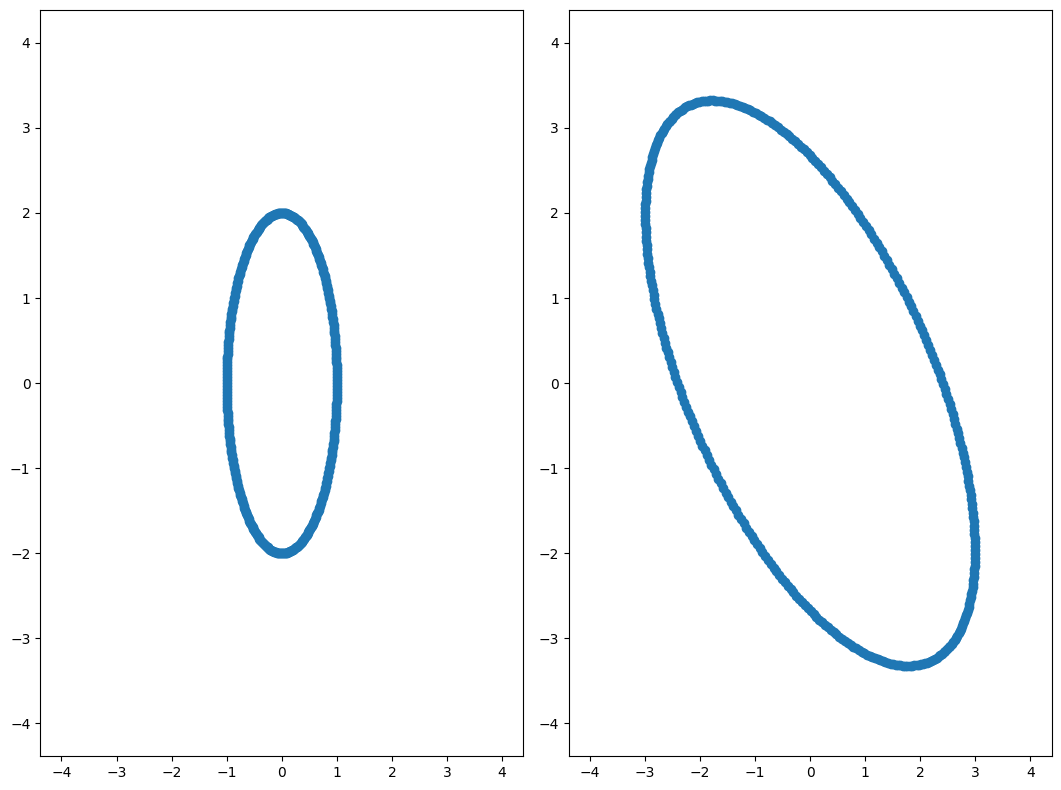

In [20]:
# Ellipse
theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
x = np.cos(theta)
y = 2*np.sin(theta)
points=np.array([x, y]).T

## Define Transformation
T = Tmatrix(scale=(2,2), rotationAngle=40, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))

## Apply trasformation
moved = np.array(applyTransformation(T, points=points)[0])

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax1.scatter(points[:,0],points[:,1])
ax2.scatter(moved[:,0],moved[:,1])

minimum = np.min((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))
maximum = np.max((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))

ax1.set_xlim(minimum*1.2,maximum*1.2)
ax1.set_ylim(minimum*1.2,maximum*1.2)
ax2.set_xlim(minimum*1.2,maximum*1.2)
ax2.set_ylim(minimum*1.2,maximum*1.2)

fig.tight_layout()
plt.show()


Now for a square

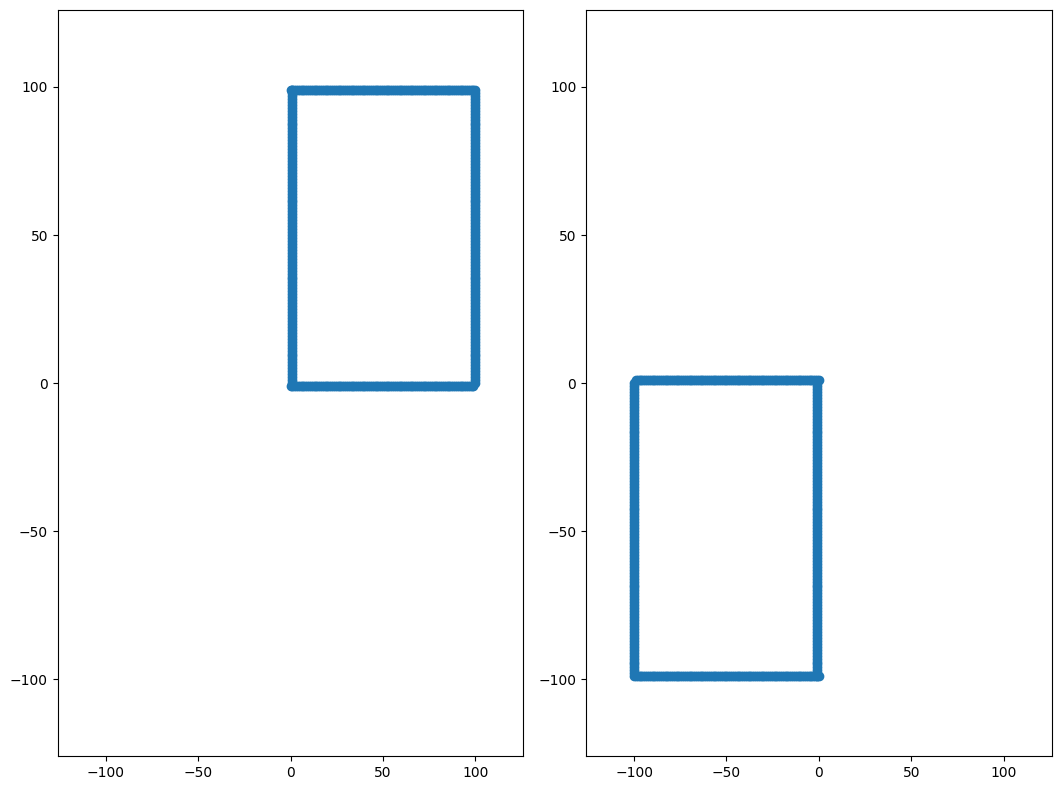

In [23]:
# Square
side_length = 2

x = np.concatenate([np.arange(100), np.arange(100), np.ones(100)*100, np.ones(100)])
y = np.concatenate([np.ones(100)*-1, np.ones(100)*99, np.arange(100), np.arange(100)])

points=np.array([x,y]).T

## Define Transformation
T = Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))

## Apply trasformation
moved = np.array(applyTransformation(T, points=points)[0])

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax1.scatter(points[:,0],points[:,1])
ax2.scatter(moved[:,0],moved[:,1])

minimum = np.min((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))
maximum = np.max((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))

ax1.set_xlim(minimum*1.2,maximum*1.2)
ax1.set_ylim(minimum*1.2,maximum*1.2)
ax2.set_xlim(minimum*1.2,maximum*1.2)
ax2.set_ylim(minimum*1.2,maximum*1.2)

fig.tight_layout()
plt.show()